In [4]:
import berreman4x4.berreman4x4 as bm
from berreman4x4.utils import SpectraRay
from lmfit import minimize, Parameters, fit_report

# Load data
Load data collected with Sentech Ellipsometer and cut the spectral range (to use Si Aspnes file)

The sample is a ALD grown TiO2 sample (with 400 cycles) on commercially available SiO2 / Si substrate.

In [43]:
tss = SpectraRay.read_psi_delta_file('TiO2_400cycles.txt').loc[400:]

# Build the model

In [44]:
sr = SpectraRay('c:/sentech/spectraray4/mat/')
Si = bm.IsotropicMaterial(sr.loadDispersionTable('Semiconductor\\IV\\Si_Aspnes.mat'))

def fit_function(params, lbda=None, psi=None, delta=None):
    SiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(params['SiO2_n0'], 
                                                    params['SiO2_n1'], 
                                                    params['SiO2_n2'], 
                                                    params['SiO2_k0'], 
                                                    params['SiO2_k1'], 
                                                    params['SiO2_k2']))
    TiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(params['TiO2_n0'], 
                                                    params['TiO2_n1'], 
                                                    params['TiO2_n2'], 
                                                    params['TiO2_k0'], 
                                                    params['TiO2_k1'], 
                                                    params['TiO2_k2']))

    Front = bm.IsotropicHalfSpace(bm.IsotropicMaterial(bm.DispersionLess(1)))  # Air
    Layer = [bm.HomogeneousLayer(TiO2, params['TiO2_d']), 
             bm.HomogeneousLayer(SiO2, params['SiO2_d'])]
    Back = bm.IsotropicHalfSpace(Si)
    S = bm.Structure(Front, Layer, Back)
    
    model = S.evaluate(lbda, 70)
    model_delta = model.Delta[:, 0, 0]
    model_delta = np.where(model_delta < 0, model_delta+360, model_delta)
    
    resid_psi = psi - model.Psi[:, 0, 0]
    resid_delta = np.deg2rad(delta) - np.deg2rad(model_delta)
    return np.concatenate((resid_psi, resid_delta))

params = Parameters()
params.add('SiO2_n0', value=1.452, min=-100, max=100, vary=False)
params.add('SiO2_n1', value=36.0, min=-40000, max=40000, vary=False)
params.add('SiO2_n2', value=0, min=-40000, max=40000, vary=False)
params.add('SiO2_k0', value=0, min=-100, max=100, vary=False)
params.add('SiO2_k1', value=0, min=-40000, max=40000, vary=False)
params.add('SiO2_k2', value=0, min=-40000, max=40000, vary=False)
params.add('SiO2_d', value=276.36, min=0, max=40000, vary=False)

params.add('TiO2_n0', value=2.236, min=-100, max=100, vary=True)
params.add('TiO2_n1', value=451, min=-40000, max=40000, vary=True)
params.add('TiO2_n2', value=251, min=-40000, max=40000, vary=True)
params.add('TiO2_k0', value=0, min=-100, max=100, vary=False)
params.add('TiO2_k1', value=0, min=-40000, max=40000, vary=False)
params.add('TiO2_k2', value=0, min=-40000, max=40000, vary=False)

params.add('TiO2_d', value=20, min=0, max=40000, vary=True)

In [41]:
out = minimize(fit_function, params, args=(tss.index.to_numpy(), tss.values[:,0], tss.values[:,1]))
out

# Show fit

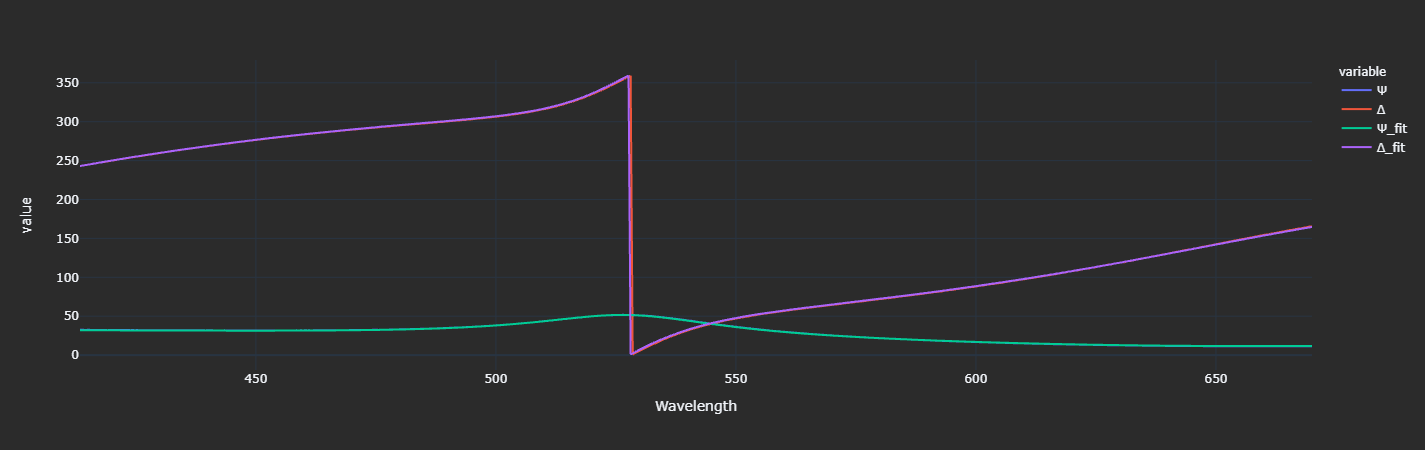

In [42]:
SiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(out.params['SiO2_n0'], out.params['SiO2_n1'], out.params['SiO2_n2'],
                                                out.params['SiO2_k0'], out.params['SiO2_k1'], out.params['SiO2_k2']))

TiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(out.params['TiO2_n0'], 
                                                out.params['TiO2_n1'], 
                                                out.params['TiO2_n2'], 
                                                out.params['TiO2_k0'], 
                                                out.params['TiO2_k1'], 
                                                out.params['TiO2_k2']))


Front = bm.IsotropicHalfSpace(bm.IsotropicMaterial(bm.DispersionLess(1)))  # Air
Layer = [bm.HomogeneousLayer(TiO2, out.params['TiO2_d']),
         bm.HomogeneousLayer(SiO2, out.params['SiO2_d'])]
Back = bm.IsotropicHalfSpace(Si)
S = bm.Structure(Front, Layer, Back)

fit = S.evaluate(tss.index.to_numpy(), 70)
fit_delta = fit.Delta[:, 0, 0]
fit_delta = np.where(fit_delta < 0, fit_delta+360, fit_delta)

pd.concat([tss, 
           pd.DataFrame({'Ψ_fit': fit.Psi[:, 0, 0],
                        'Δ_fit': fit_delta}, 
                        index=tss.index)]
         ).plot()